In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython.display import Audio
%matplotlib inline

In [2]:
outputs = h5py.File("/work/asr3/rossenbach/rilling/sisyphus_work_dirs/glow_tts_asr/i6_core/returnn/forward/ReturnnForwardJob.by6neT42F3XY/output/output.hdf", "r")
outputs.keys()

<KeysViewHDF5 ['inputs', 'labels', 'seqLengths', 'seqTags']>

In [3]:
spectograms = np.array(outputs["inputs"])
lengths = np.array(outputs["seqLengths"])[:, 0]
spectograms.shape, lengths[0]

((360684, 80), 170)

In [4]:
np.max(lengths)

578

In [5]:
def get_spec_for_index(specs, lengths, index):
    start = 0
    end = 0
    for i in range(index+1):
        start = end
        end += lengths[i]
    return specs[start:end].T

In [24]:
index = 50
spec = get_spec_for_index(spectograms, lengths, index)

In [25]:
gt_specs = torch.load("/u/lukas.rilling/experiments/glow_tts_asr/audio_features_first_batch.pt").detach().cpu().numpy()

gt_spec = gt_specs[index]
gt_spec[index]


array([-0.8654627 , -0.7809518 , -0.92239726, -0.8703378 , -0.72816855,
       -0.8079019 , -0.7350123 , -0.9415965 , -1.1245002 , -1.2234709 ,
       -1.2301236 , -1.178274  , -0.7966849 ,  0.49515024,  1.2682997 ,
        1.5440519 ,  1.4553177 ,  1.1854444 ,  1.6678293 ,  1.9271888 ,
        2.0404143 ,  2.13011   ,  2.0710716 ,  2.03327   ,  1.9433459 ,
        1.6429406 ,  1.7075716 ,  1.5232373 ,  1.0907263 ,  0.8652346 ,
        0.714458  ,  0.80687696,  0.55448186, -0.38283023,  0.9018968 ,
        1.584458  ,  2.1239274 ,  2.323441  ,  2.4086409 ,  2.4701688 ,
        2.5596497 ,  2.6998034 ,  2.576692  ,  2.086072  ,  1.737033  ,
        1.5919349 ,  1.7296072 ,  2.3025675 ,  2.449635  ,  2.2205644 ,
        1.8168516 ,  1.4142613 ,  1.2158866 ,  1.3340881 ,  1.4186417 ,
        2.0594454 ,  2.341001  ,  2.4740922 ,  2.5345685 ,  2.3827908 ,
        2.130265  ,  1.7396598 ,  1.3809938 ,  1.0529621 ,  0.7168644 ,
        0.39899293,  1.2702512 ,  1.990366  ,  1.9973649 ,  1.80

In [33]:
def plot_spec(spec):
    fig, ax = plt.subplots()
    shape = spec.shape
    x = np.arange(0, shape[0]+1)
    y = np.arange(0, shape[1]+1)

    ax.pcolormesh(spec[:, :shape[1]])
    plt.show()


In [37]:
gt_spec.shape, spec.shape

((80, 411), (80, 126))

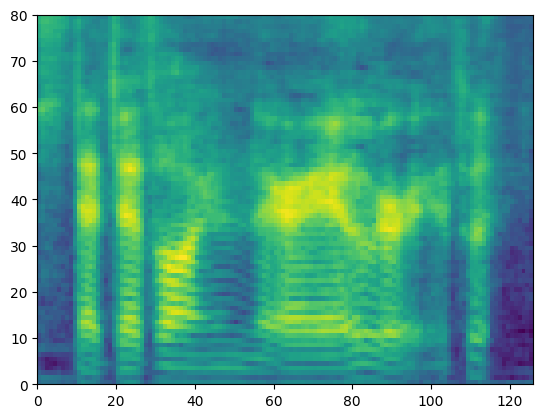

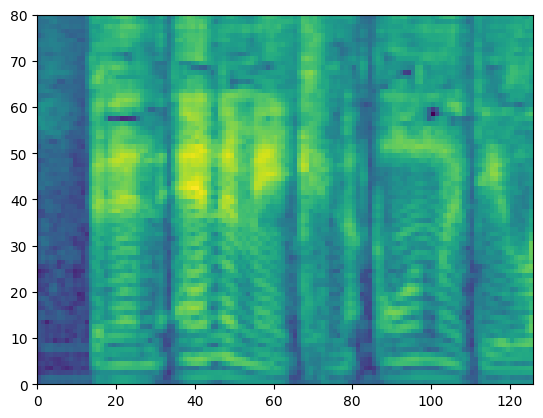

In [39]:
plot_spec(spec)
plot_spec(gt_spec[:, :spec.shape[1]])

In [28]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
#   waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [29]:
def inv_preemphasis(wav, preemphasis):
        """
        :param np.array wav:
        :param float k:
        :return:
        """
        from scipy import signal
        return signal.lfilter([1], [1, -preemphasis], wav)

In [30]:
def get_waveform_of_spec(spec):
    norm_std_dev = 30.906690797087478
    norm_mean = -76.49818038940428

    # s = spec.detach().cpu().numpy()
    s = spec.copy()
    print(np.min(s), np.max(s))
    s *= norm_std_dev
    s += norm_mean
    s /= 20
    s = np.power(10,s)
    print(np.min(s), np.max(s))
    num_freq = 1024
    iverse_mel = torchaudio.transforms.InverseMelScale(num_freq // 2 + 1, 80, f_min=60, f_max=7600, sample_rate=16000)
    spec_tensor = torch.Tensor(s)
    power_spec = iverse_mel(spec_tensor)
    
    power_spec[:5,:] = 0
    power_spec[-55:,:] = 0
    plot_spec(power_spec)
    print(torch.sum(power_spec, 1))
    print(f"spec.shape: {spec.shape}")
    print(f"power_spec.shape: {power_spec.shape}")
    griffin_lim = torchaudio.transforms.GriffinLim(num_freq, win_length=int(0.05*16000), hop_length=int(0.0125*16000))

    wave = griffin_lim(power_spec)
    wave = wave.unsqueeze(0)
    wave = inv_preemphasis(wave, 0.97)
    plot_waveform(wave)
    return Audio(wave, rate=16000)


-2.0249596 1.9559442
1.11135094e-07 0.15764469


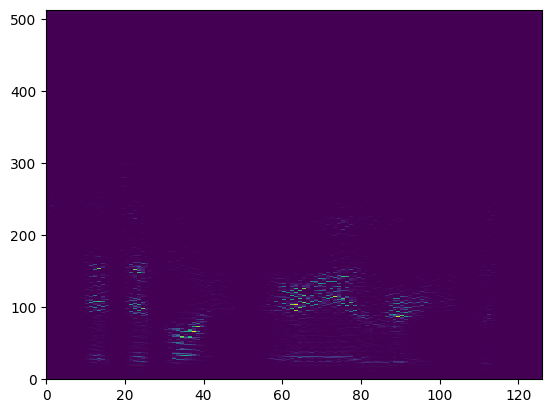

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6292e-04,
        1.8749e-04, 3.3955e-03, 4.1982e-03, 9.3659e-03, 2.5140e-02, 1.4519e-02,
        1.0188e-02, 1.1803e-02, 2.0758e-02, 1.4253e-02, 1.4513e-02, 1.9451e-02,
        2.4785e-02, 5.5592e-02, 3.7275e-02, 4.4653e-02, 9.7623e-02, 1.8971e-01,
        2.7190e-01, 4.3071e-01, 1.2080e-01, 2.4807e-01, 1.7330e-01, 3.5988e-01,
        2.1151e-01, 4.3814e-01, 1.4724e-01, 3.0170e-01, 1.2353e-01, 2.1153e-01,
        1.2997e-01, 1.1504e-01, 7.0503e-02, 4.5129e-02, 4.9983e-02, 1.4306e-01,
        5.7923e-02, 8.8599e-02, 3.5327e-02, 4.3527e-02, 4.3133e-02, 4.6287e-02,
        9.4103e-02, 8.1063e-02, 9.7513e-02, 1.7288e-01, 5.3679e-02, 2.0036e-02,
        6.0285e-02, 4.7489e-02, 4.6900e-02, 2.4326e-01, 2.4297e-01, 2.5156e-01,
        1.2292e-01, 3.7692e-02, 7.7501e-02, 7.2418e-02, 4.0057e-02, 1.2216e-01,
        3.8124e-01, 1.6946e-01, 3.0124e-01, 1.6423e-01, 1.2657e-01, 4.6482e-02,
        7.6741e-02, 2.5330e-01, 7.7076e-

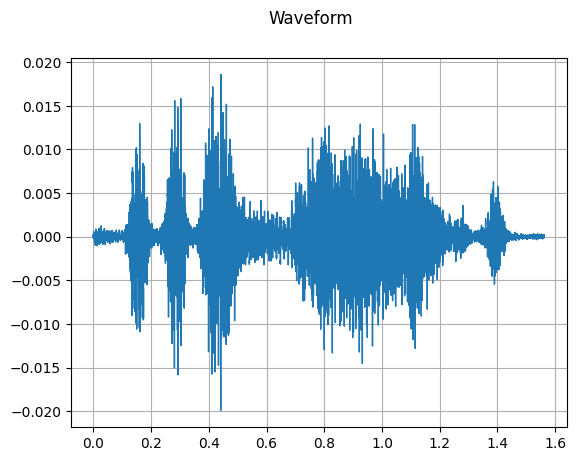

In [31]:
get_waveform_of_spec(spec)


-2.7655625 2.9601345
7.968415e-09 5.616803


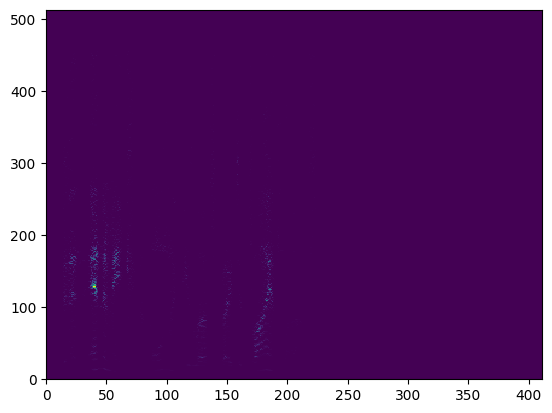

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4929e-03,
        6.1288e-03, 1.0214e-01, 4.9233e-02, 7.9117e-02, 1.3924e-01, 4.1835e-01,
        6.4582e-01, 9.0082e-01, 3.8039e-01, 2.1866e-01, 8.0546e-02, 9.0767e-02,
        1.4374e-01, 4.3799e-01, 2.4964e-01, 1.3077e-01, 1.6288e-01, 3.6149e-01,
        4.2883e-01, 3.1067e-01, 2.9904e-01, 4.5120e-01, 6.4057e-01, 1.7325e+00,
        1.3319e+00, 1.6812e+00, 3.6195e-01, 6.2038e-01, 5.6377e-01, 1.0992e+00,
        1.0479e+00, 4.2459e-01, 8.3086e-01, 6.1422e-01, 8.2788e-01, 6.1957e-01,
        5.3574e-01, 1.2864e+00, 6.4332e-01, 1.0869e+00, 1.1105e+00, 3.4634e-01,
        8.2843e-01, 5.3387e-01, 3.8594e-01, 6.8023e-01, 2.7364e-01, 3.9546e-01,
        4.6908e-01, 7.3066e-01, 4.3097e-01, 8.2887e-01, 6.9174e-01, 3.0420e-01,
        6.7156e-01, 4.0412e-01, 3.9669e-01, 5.6601e-01, 4.0491e-01, 1.2655e+00,
        1.7736e+00, 4.6838e-01, 8.7150e-01, 8.5829e-01, 1.2478e+00, 1.1070e+00,
        8.5609e-01, 1.2035e+00, 1.1407e+

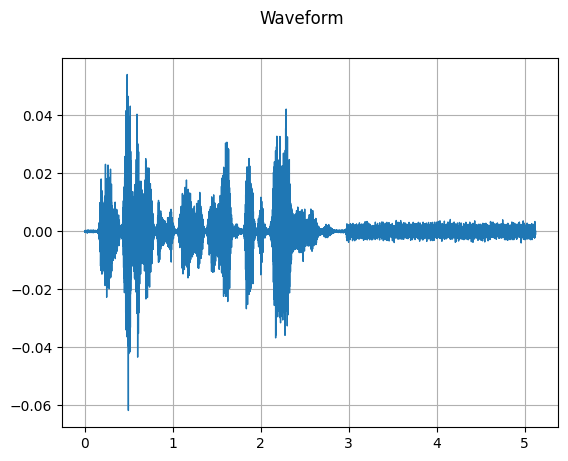

In [32]:
get_waveform_of_spec(gt_spec)